In [1]:
import get_surya 
import get_funsd 


In [2]:
funsd = get_funsd.CustomFunsdDataset()
funsd.split_generators()

In [3]:
funsd['train'][0].keys()

dict_keys(['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'])

In [4]:
surya = get_surya.CustomSuryaDataset()
surya.split_generators()

In [308]:
surya['train'][0].keys()

dict_keys(['id', 'tokens', 'line_boxes', 'image', 'image_name'])

In [310]:
funsd['train'][0]['linkings']

[None,
 None,
 [16],
 [12],
 [13],
 [19],
 [19],
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 [11],
 [11],
 [11],
 [11],
 [11],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [3],
 [3],
 [3],
 [4],
 [4],
 [15],
 [15],
 [15],
 [14],
 [14],
 [14],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [18],
 [18],
 [18],
 [18],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [17],
 [6, 7],
 [6, 7],
 [6, 7],
 [6, 7],
 [6, 7],
 [6, 7],
 [21, 22],
 [21, 22],
 [20],
 [20],
 [20],
 [20],
 [20],
 [20],
 [20],
 [20],
 [20],
 [20],
 [20],
 None,
 None,
 None]

In [49]:
def iou(gt_box, ocr_line_box):
    x1, y1, x2, y2 = gt_box
    x1_p, y1_p, x2_p, y2_p = ocr_line_box

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    gt_box_area = (x2 - x1) * (y2 - y1)
    ocr_line_box_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    union_area = gt_box_area + ocr_line_box_area - inter_area
    return inter_area / union_area if union_area else 0
  

In [50]:
def is_box_inside(inner_box, outer_box, tolerance=0):
    """
    Check if inner_box is inside outer_box with a given tolerance for error.
    
    Args:
    - inner_box: [x_min, y_min, x_max, y_max] for the inner box.
    - outer_box: [x_min, y_min, x_max, y_max] for the outer box.
    - tolerance: Allowed deviation (error) for the box positions and dimensions.
    
    Returns:
    - True if inner_box is inside outer_box within the given tolerance, else False.
    """
    # Check if inner_box is inside outer_box with the given tolerance
    return (
        inner_box[0] >= outer_box[0] - tolerance and  # inner x_min >= outer x_min - tolerance
        inner_box[1] >= outer_box[1] - tolerance and  # inner y_min >= outer y_min - tolerance
        inner_box[2] <= outer_box[2] + tolerance and  # inner x_max <= outer x_max + tolerance
        inner_box[3] <= outer_box[3] + tolerance      # inner y_max <= outer y_max + tolerance
    )

# Example boxes
inner_box = [10, 10, 20, 20]
outer_box = [5, 5, 25, 25]

# Checking with a tolerance of 2
result = is_box_inside(inner_box, outer_box, tolerance=2)

print(result)  # Output will be True



True


In [306]:
surya

CustomFunsdDataset:
DatasetDict({
    train: Dataset({features: ['id', 'tokens', 'line_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 149}),
    test: Dataset({features: ['id', 'tokens', 'line_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 50})
})

In [79]:
len(surya['train'][0]['tokens']), len(funsd['train'][0]['tokens']), c

(170, 145, 151)

In [276]:
def get_gt_tokens_not_found(image_index):
         
    found_gt_tokens = {str(funsd['train'][image_index]['tokens'][i])+'_'+f'{i}':0 
                    for i in range(len(funsd['train'][image_index]['tokens']))}


    surya_line_boxes = surya['train'][image_index]['line_boxes']
    surya_unique_line_boxes = list(dict.fromkeys(tuple(box) for box in surya_line_boxes))
    funsd_bboxes = funsd['train'][image_index]['bboxes']
    c=0
    for i, surya_line_box in enumerate(surya_unique_line_boxes):
        for j, box in enumerate(funsd_bboxes):
            
            if is_box_inside(box, surya_line_box,tolerance=10):
                # print(iou_score)
                # for bi, b in enumerate(surya_line_boxes):
                #     if b == list(surya_line_box):
                #         print(surya['train'][image_index]['tokens'][bi],end=' ')
                # print('')
                # print(box, surya_line_box)
                # print(funsd['train'][image_index]['tokens'][j])
                # print('_______________'*4)
                
                found_gt_tokens[str(funsd['train'][image_index]['tokens'][j])+'_'+f'{j}']=1
                c+=1
    gt_tokens_not_found = [key for key, value in found_gt_tokens.items() if value == 0]
    print(gt_tokens_not_found, len(gt_tokens_not_found))
    

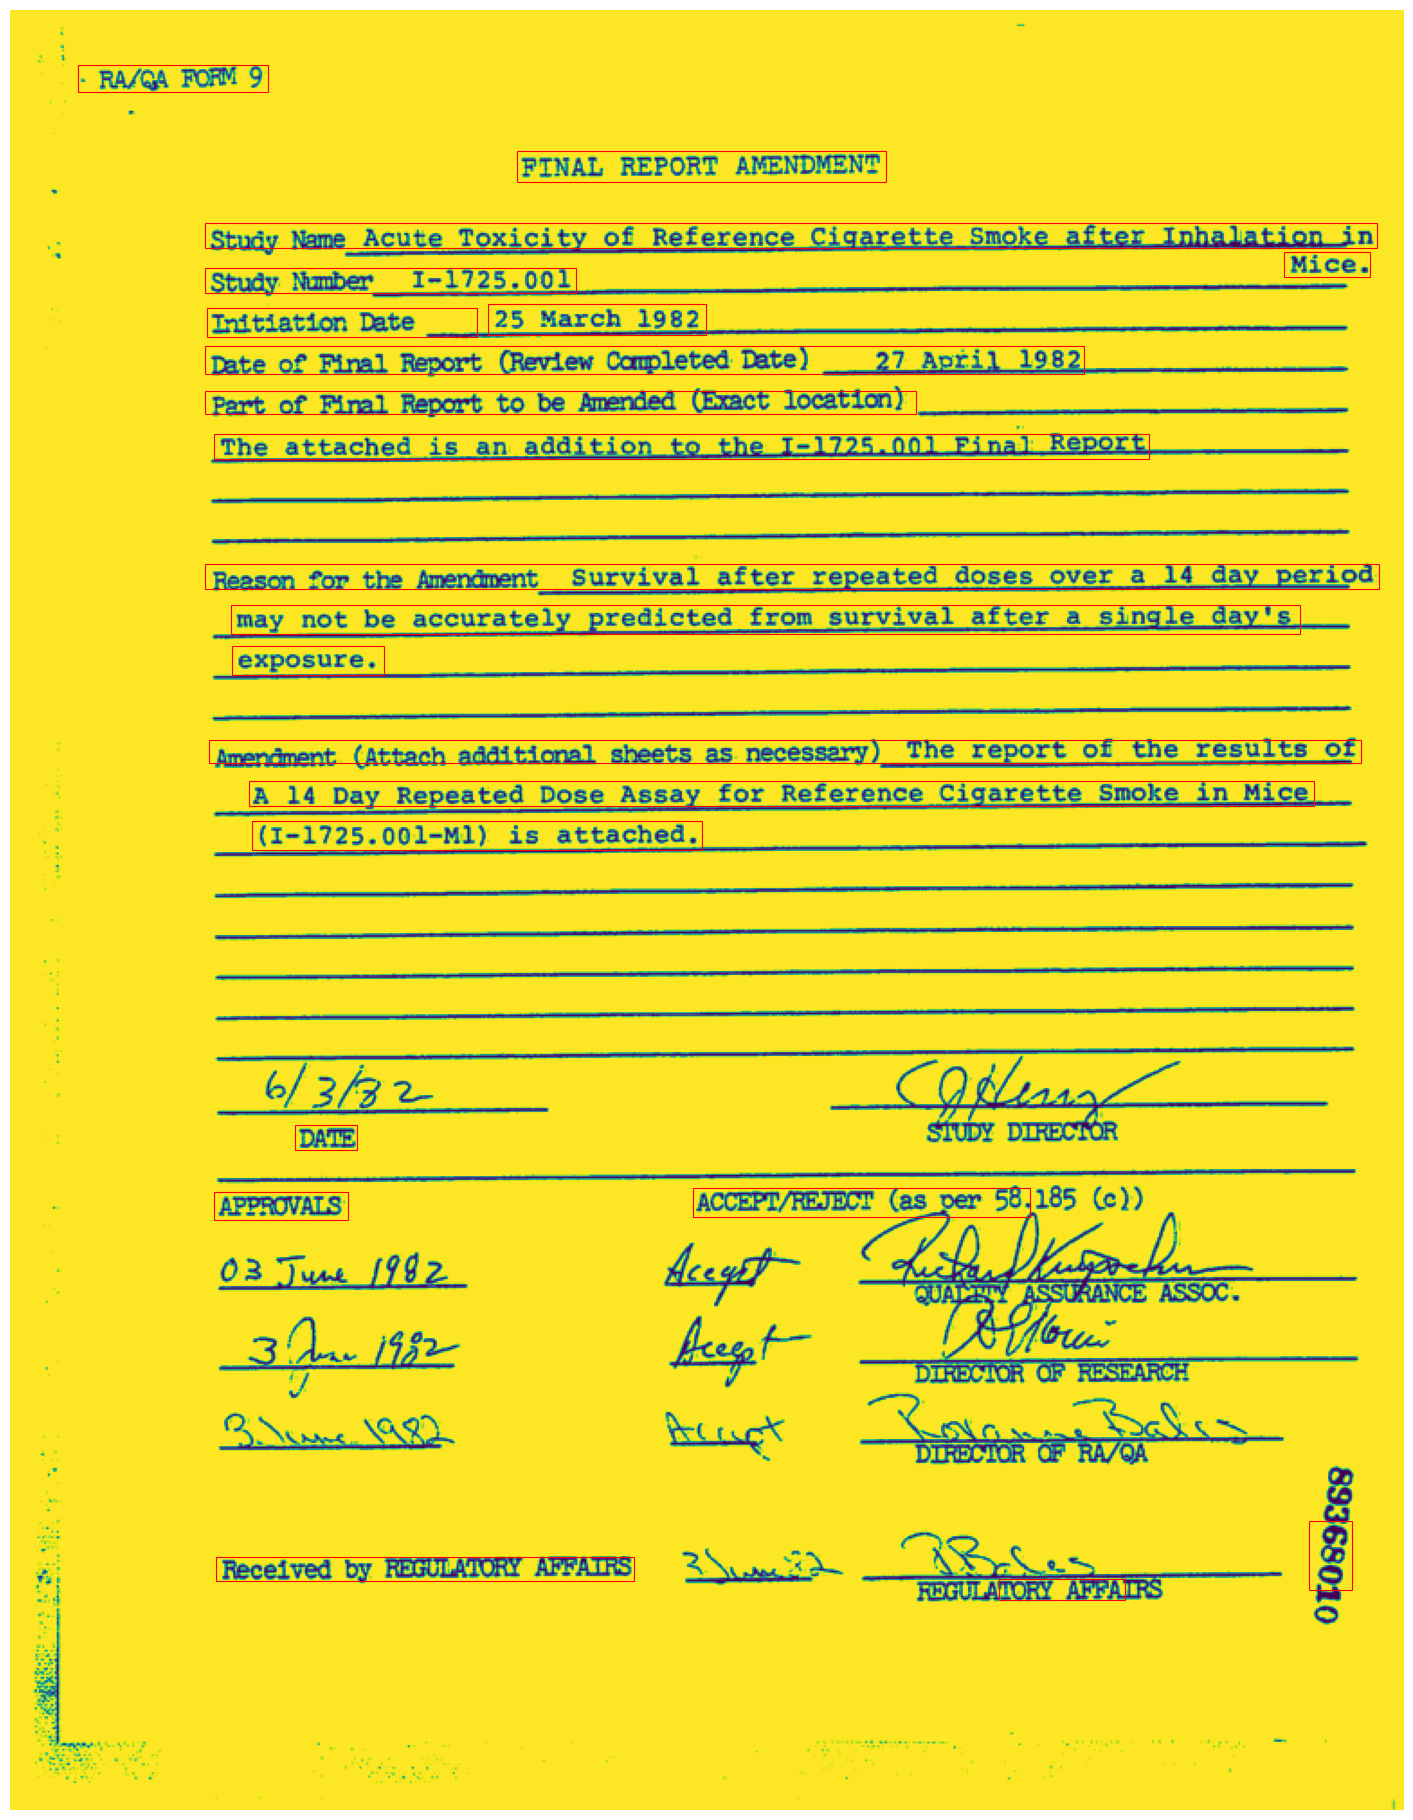

In [305]:
from PIL import Image
import matplotlib.pyplot as plt
import io 

i=113
image = surya['train'][i]['image']
fig, ax = plt.subplots(1, figsize=(20, 18))
ax.imshow(image)
surya_unique_line_boxes = list(dict.fromkeys(tuple(box) for box in surya['train'][i]['line_boxes']))
for pred in surya_unique_line_boxes:

    x0, y0, x1, y1 = pred
    width = x1 - x0
    height = y1 - y0
    rect = plt.Rectangle((x0, y0), width, height, fill=False, color='r', linewidth=0.8)
    ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout(pad=0)

    

In [302]:
get_gt_tokens_not_found(118)

['91161344_93'] 1
